In [4]:
#imports
import pymongo as pm #import MongoClient only
from pymongo import MongoClient
import pprint # prettyprinting for json objects
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from datetime import timedelta

#Connexion
client = pm.MongoClient('bigdatadb.polito.it',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)
db = client['carsharing'] #DB to use
Bookings_collection = db['PermanentBookings']


#STEP 2 : Car sharing usage

# Collections
bookings_collection = db['PermanentBookings']
parkings_collection = db['PermanentParkings']

#Range for quering
start_date = datetime(2017, 11, 1)  #2017/11/1
end_date = datetime(2018, 1, 31, 23, 59, 59) #2018/01/31 23:59:59

# Our cities
cities = ["Madrid", "Denver", "Austin"]

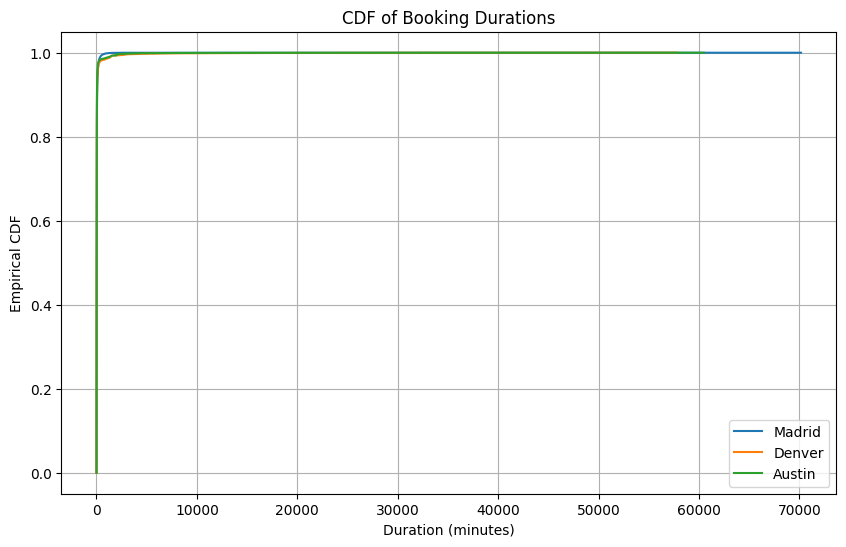

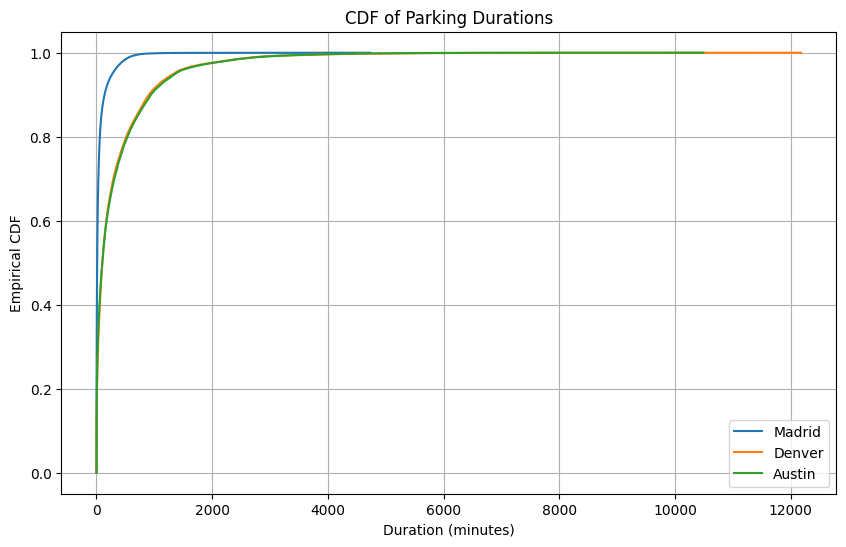

In [5]:
#QUESTION 1
# A and B
# Created to get the durations
def get_durations(collection, city):
    #my query what I need
    query = {
        'city': city,
        'init_date': {'$gte': start_date, '$lte': end_date}, #$gte (greater than or equal) $lte (less than or equal)
        'final_date': {'$exists': True}  
    }
    # Fields to retrieve inicializo lo que voy a rellenenar
    projection = {
        '_id': 0, #esta excluido
        'init_date': 1, #incluidos por el 1
        'final_date': 1
    }
    data = list(collection.find(query, projection)) #en la coleccion guardo una lista con los valores
    # Convert in panda dt frame
    df = pd.DataFrame(data)
    df['init_date'] = pd.to_datetime(df['init_date'])
    df['final_date'] = pd.to_datetime(df['final_date'])
    # Calculate the duration
    df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60 #dt.total_seconds() herramienta d pds

    # Filter out any negative or zero durations
    df = df[df['duration'] > 0]
    return df['duration']

#Dicc to save the durations
booking_durations = {}
parking_durations = {}

# Durations of which city
for city in cities:
    booking_durations[city] = get_durations(bookings_collection, city)
    parking_durations[city] = get_durations(parkings_collection, city)
    
#to plot the data
def plot_cdf(durations_dict, title):
    plt.figure(figsize=(10, 6))
    for city, durations in durations_dict.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=city)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot CDFs for bookings
plot_cdf(booking_durations, 'CDF of Booking Durations')

# Plot CDFs for parkings
plot_cdf(parking_durations, 'CDF of Parking Durations')

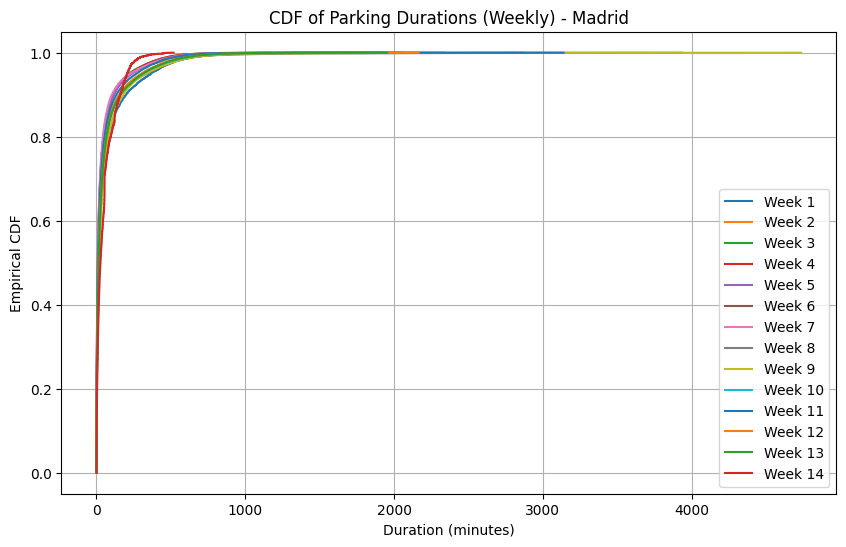

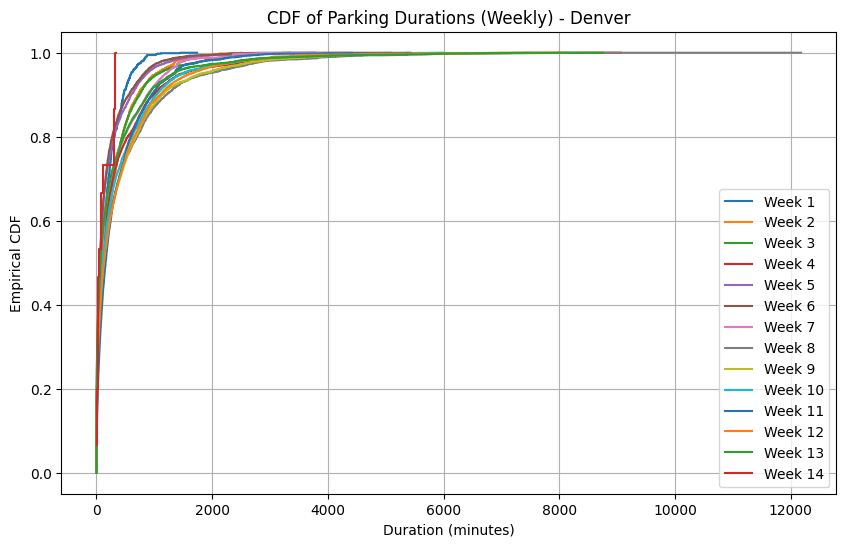

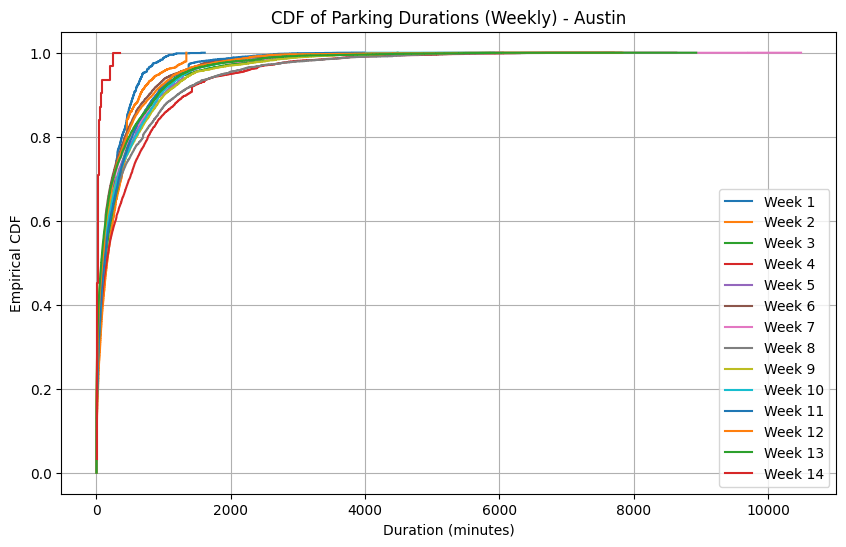

In [7]:
# C
#To take the duractions by weekly periods for one city
def get_weekly_durations(collection, city):
    weekly_durations = {}
    start_date = datetime(2017, 11, 1)
    end_date = datetime(2018, 1, 31, 23, 59, 59)
    week = 0

    while start_date < end_date:
        week_end = start_date + timedelta(days=7)
        # Query to filter by city and weekly date range
        query = {
            'city': city,
            'init_date': {'$gte': start_date, '$lt': week_end},
            'final_date': {'$exists': True}
        }
        #compute duration as before
        data = list(collection.find(query, {'_id': 0, 'init_date': 1, 'final_date': 1}))
        df = pd.DataFrame(data)
        if not df.empty:
            df['init_date'] = pd.to_datetime(df['init_date'])
            df['final_date'] = pd.to_datetime(df['final_date'])
            df['duration'] = (df['final_date'] - df['init_date']).dt.total_seconds() / 60
            df = df[df['duration'] > 0]
            weekly_durations[f"Week {week + 1}"] = df['duration']
        start_date = week_end
        week += 1

    return weekly_durations
#plot 
for city in cities:
    weekly_durations = get_weekly_durations(parkings_collection, city)
    plt.figure(figsize=(10, 6))
    for week, durations in weekly_durations.items():
        sorted_data = np.sort(durations)
        yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
        plt.step(sorted_data, yvals, label=week)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Empirical CDF')
    plt.title(f'CDF of Parking Durations (Weekly) - {city}')
    plt.legend()
    plt.grid(True)
    plt.show()

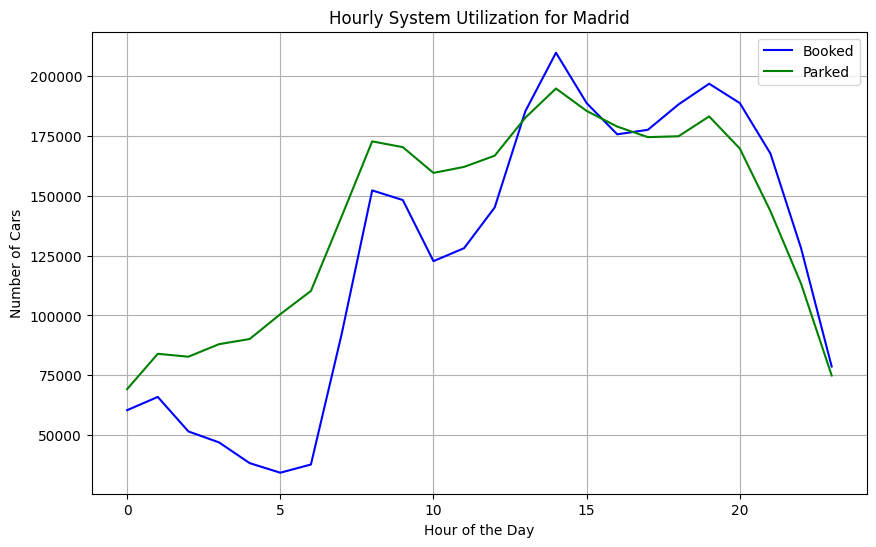

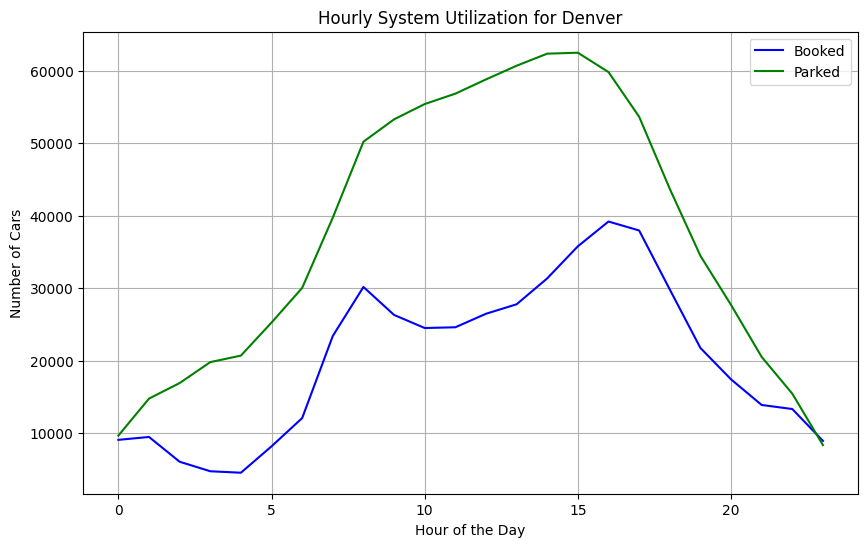

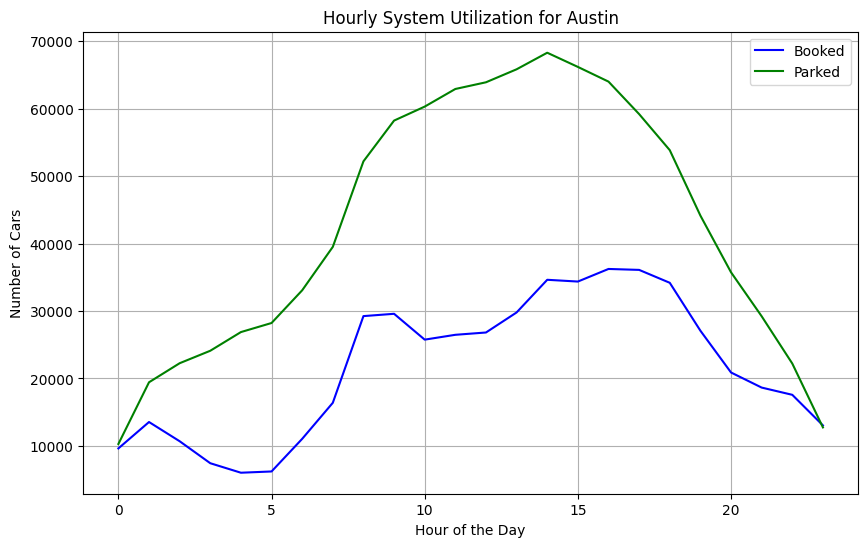

In [9]:
#QUESTION 2
# Function to add bookings/parkings per hour
#take the count of booked/parking cards for the select city
def get_hourly_utilization(collection, city, status_field):
    query = {'city': city}
    projection = {
        '_id': 0,
        'init_date': 1,
        'final_date': 1
    }
    
    data = list(collection.find(query, projection))
    df = pd.DataFrame(data)
    
    # Filter out any rows with missing dates
    df = df.dropna(subset=['init_date', 'final_date'])

    # to datetime
    df['init_date'] = pd.to_datetime(df['init_date'])
    df['final_date'] = pd.to_datetime(df['final_date'])

    # dataframe to track the hours
    hourly_counts = pd.DataFrame(0, index=range(24), columns=['count'])

    # increment hourly counts of each
    for _, row in df.iterrows():
        start_hour = row['init_date'].hour
        end_hour = row['final_date'].hour
        
        # Increment the count for each hour within the booking/parking period
        for hour in range(start_hour, end_hour + 1):
            if hour in hourly_counts.index:
                hourly_counts.loc[hour, 'count'] += 1

    return hourly_counts

#do it and plot it
for city in cities:
    # Get hourly booked and parked counts
    booked_hourly = get_hourly_utilization(bookings_collection, city, 'booked')
    parked_hourly = get_hourly_utilization(parkings_collection, city, 'parked')

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(booked_hourly.index, booked_hourly['count'], label='Booked', color='blue')
    plt.plot(parked_hourly.index, parked_hourly['count'], label='Parked', color='green')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Cars')
    plt.title(f'Hourly System Utilization for {city}')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
#QUESTION 4
# Queries for filtered data
filtered_query = {
    "city": {"$in": cities},
    "init_date": {"$gte": start_date, "$lte": end_date},
    "final_date": {"$exists": True}  
}

# Load unfiltered data
df_bookings_unfiltered = pd.DataFrame(list(db['PermanentBookings'].find(filtered_query)))
df_parkings_unfiltered = pd.DataFrame(list(db['PermanentParkings'].find(filtered_query)))

# Ensure init_date and final_date are in datetime format
df_bookings_unfiltered['init_date'] = pd.to_datetime(df_bookings_unfiltered['init_date'])
df_bookings_unfiltered['final_date'] = pd.to_datetime(df_bookings_unfiltered['final_date'])
df_parkings_unfiltered['init_date'] = pd.to_datetime(df_parkings_unfiltered['init_date'])
df_parkings_unfiltered['final_date'] = pd.to_datetime(df_parkings_unfiltered['final_date'])

# Calculate duration(min) for both
df_bookings_unfiltered['duration'] = (df_bookings_unfiltered['final_date'] - df_bookings_unfiltered['init_date']).dt.total_seconds() / 60
df_parkings_unfiltered['duration'] = (df_parkings_unfiltered['final_date'] - df_parkings_unfiltered['init_date']).dt.total_seconds() / 60

# Define our duration thresholds(in minutes)
MIN_DURATION = 2      
MAX_DURATION = 1440   # 24 h

#funtion for aplly our thresholds
def filter_data(df):
    df_filtered = df[(df['duration'] > MIN_DURATION) & (df['duration'] < MAX_DURATION)]
    
    # Calculate IQR
    Q1 = df_filtered['duration'].quantile(0.25)
    Q3 = df_filtered['duration'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # apply the IQR range
    df_filtered = df_filtered[(df_filtered['duration'] >= lower_bound) & (df_filtered['duration'] <= upper_bound)]
    return df_filtered

# apply the filter
df_bookings_filtered = filter_data(df_bookings_unfiltered)
df_parkings_filtered = filter_data(df_parkings_unfiltered)

# calculate the hourly utilitation
def calculate_hourly_utilization(df):
    df['hour'] = df['init_date'].dt.hour  #take the hour
    hourly_utilization = df.groupby('hour').size()  # occurrences per hour
    return hourly_utilization.reindex(range(24), fill_value=0)  # Ensure all hours are included

# Unfiltered hour utilization
booked_hourly_unfiltered = calculate_hourly_utilization(df_bookings_unfiltered)
parked_hourly_unfiltered = calculate_hourly_utilization(df_parkings_unfiltered)

# Filtered utilization
booked_hourly_filtered = calculate_hourly_utilization(df_bookings_filtered)
parked_hourly_filtered = calculate_hourly_utilization(df_parkings_filtered)

hours = range(24)

#plot both for make a comparation
# Plot unfiltered utilization
plt.figure(figsize=(12, 6))
plt.plot(hours, booked_hourly_unfiltered, label='Booked (Unfiltered)', color='blue', linestyle='--')
plt.plot(hours, parked_hourly_unfiltered, label='Parked (Unfiltered)', color='green', linestyle='--')

# Plot filtered utilization
plt.plot(hours, booked_hourly_filtered, label='Booked (Filtered)', color='blue')
plt.plot(hours, parked_hourly_filtered, label='Parked (Filtered)', color='green')

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Cars')
plt.title('Hourly System Utilization Before and After Filtering')
plt.legend()
plt.grid()
plt.show()

def plot_cdf(data, title, label):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / float(len(sorted_data))
    plt.step(sorted_data, yvals, label=label)
    
# Plot CDFs for bookings
plt.figure(figsize=(10, 6))
plot_cdf(df_bookings_unfiltered['duration'], 'CDF of Booking Durations', 'Unfiltered Bookings')
plot_cdf(df_bookings_filtered['duration'], 'CDF of Booking Durations', 'Filtered Bookings')
plt.xlabel('Duration (minutes)')
plt.ylabel('Empirical CDF')
plt.title('CDF of Booking Durations Before and After Filtering')
plt.legend()
plt.grid()
plt.show()

# Plot CDFs for parkings
plt.figure(figsize=(10, 6))
plot_cdf(df_parkings_unfiltered['duration'], 'CDF of Parking Durations', 'Unfiltered Parkings')
plot_cdf(df_parkings_filtered['duration'], 'CDF of Parking Durations', 'Filtered Parkings')
plt.xlabel('Duration (minutes)')
plt.ylabel('Empirical CDF')
plt.title('CDF of Parking Durations Before and After Filtering')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#QUESTION 5
# Calculate daily statistics 
def compute_daily_statistics(df):
    #take the date
    df['date'] = df['init_date'].dt.date
    
    # Group by date and compute statistics
    daily_stats = df.groupby('date')['duration'].agg(
        average='mean',
        median='median',
        std_dev='std',
        p25=lambda x: x.quantile(0.25),
        p50=lambda x: x.quantile(0.5),
        p75=lambda x: x.quantile(0.75)
    ).reset_index()
    
    return daily_stats

# Compute statistics for bookings and parkings
daily_stats_bookings = compute_daily_statistics(df_bookings_filtered)
daily_stats_parkings = compute_daily_statistics(df_parkings_filtered)

# Display the statistics for the first few days to verify
print("Daily Statistics for Bookings:")
print(daily_stats_bookings.head())

print("Daily Statistics for Parkings:")
print(daily_stats_parkings.head())

def plot_daily_statistics(daily_stats, title):
    plt.figure(figsize=(14, 8))
    
    plt.plot(daily_stats['date'], daily_stats['average'], label='Average', color='blue')
    plt.plot(daily_stats['date'], daily_stats['median'], label='Median', color='orange')
    plt.fill_between(daily_stats['date'], daily_stats['p25'], daily_stats['p75'], color='grey', alpha=0.3, label='Interquartile Range (25th-75th percentile)')
    plt.plot(daily_stats['date'], daily_stats['std_dev'], label='Standard Deviation', color='green')

    plt.xlabel('Date')
    plt.ylabel('Duration (minutes)')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Plot statistics for bookings and parkings
plot_daily_statistics(daily_stats_bookings, 'Daily Statistics of Booking Durations')
plot_daily_statistics(daily_stats_parkings, 'Daily Statistics of Parking Durations')